# Object Localization with RetinaNet

The task of object localization involves drawing bounding boxes around objects and assigning labels to them.

In this exercise you will fine-tune a pre-trained RetinaNet model for use on a self-driving car. In particular, we will use a subset of the Udacity self-driving car dataset.

The dataset contains 18000 training images and 4241 test images, of shape 480x300, corresponding to 132406 objects in the training set and 32699 objects in the test set. We are going to use 1/5th of the dataset in order to make the training achievable in a reasonable time frame for our class.

This is an example of an image from the dataset with the annotations:

<center><img src="notebook_ims/udacity_self_driving_example.png"></center>

Let's start by getting the data loaders. Since the directory structure of this dataset is non-standard, we have prepared a dataset class for you. Feel free to check out the `UdacitySelfDrivingDataset` class in the ``helpers.py`` module.

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 37.1 MB 126 kB/s eta 0:00:01    |█                               | 1.3 MB 4.7 MB/s eta 0:00:08     |██▍                             | 2.8 MB 4.7 MB/s eta 0:00:08     |███▊                            | 4.3 MB 4.7 MB/s eta 0:00:07     |█████                           | 5.7 MB 4.7 MB/s eta 0:00:07     |█████████████▉                  | 16.0 MB 6.7 MB/s eta 0:00:04     |████████████████▍               | 19.1 MB 6.7 MB/s eta 0:00:03     |███████████████████             | 22.1 MB 6.7 MB/s eta 0:00:03     |███████████████████▋            | 22.8 MB 6.7 MB/s eta 0:00:03     |██████████████████████          | 25.5 MB 6.7 MB/s eta 0:00:02     |███████████████████████▎        | 27.0 MB 9.5 MB/s eta 0:00:02     |████████████████████████▌       | 28.4 MB 9.5 MB/s eta 0:00:01     |███████████████████████████     | 31.4 MB 9.5 MB/s eta 0:00:01     |███████████████████████████▋    | 32.

     |████████████████████████████████| 98 kB 4.4 MB/s  eta 0:00:01
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257186 sha256=d10f23f1a11a74f3be666fc8d77350c82b6597e44e85a572bb02d54e36bbd7dc
  Stored in directory: /root/.cache/pip/wheels/f7/55/ff/f3d7554e69382d31cf7ad857cf518af9b923134fca7d925187
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=273738 sha256=f5e1fb2e959a9e9e4553556b0d0d3d3b57b0634bae140163c4ad90ed58c5c011
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built bokeh pycocotools


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


> Now restart the notebook, then continue from the next cell

In [2]:
from helpers import get_data_loaders

# The parameter "thinning" controls how much of the data we are
# actually using. A thinning of 1 means "use all of the data", 
# which would be optimal but very slow on this hardware. So we use
# thinning=5, i.e., we use one out of 5 images from the dataset
# (i.e. we reduce the dataset size by 5x). This is only for teaching
# purposes, to make the exercise complete in a reasonable time
data_loaders = get_data_loaders("data", batch_size=2, thinning=5)

Keeping 3600 of 18000 images
Keeping 26648 objects out of 132406
Keeping 3600 of 18000 images
Keeping 26648 objects out of 132406
Keeping 849 of 4241 images
Keeping 6528 objects out of 32699


These are the classes for this dataset:

In [2]:
print(data_loaders['train'].dataset.classes)

['car', 'truck', 'pedestrian', 'bicyclist', 'light']


## Defining the Model

For this exercise, we are going to use ``torchvision`` and get a pre-trained RetinaNet model using a ResNet 50 as backbone with Feature Pyramid:

<center><img src="notebook_ims/retinanet.png"></center>

In [3]:
import torchvision.models
import torch
import math

# Fetch a pre-trained retinanet based on Feature Pyramid Network resnet50
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# In RetinaNet the background is a class of its own, so
# the number of classes is equal to the classes in the dataset
# plus 1
num_classes = len(data_loaders["train"].dataset.classes) + 1

# Get the number of inputs and the number of anchors from the existing
# classification head
in_features = model.head.classification_head.conv[0].in_channels
num_anchors = model.head.classification_head.num_anchors

# Set the number of classes to what we need
model.head.classification_head.num_classes = num_classes

# Create custom head
custom_head = torch.nn.Conv2d(
    in_features, num_anchors * num_classes, kernel_size=3, stride=1, padding=1
)

# Initialize weights and biass
# From the paper, see section 4.1 "Initialization" of https://arxiv.org/pdf/1708.02002.pdf
torch.nn.init.normal_(custom_head.weight, std=0.01)
torch.nn.init.constant_(custom_head.bias, -math.log((1 - 0.01) / 0.01))

# Replace existing head with the one we just created
model.head.classification_head.cls_logits = custom_head

> Training this model on our dataset requires many hours of training, especially on a single GPU. In order to cut down this time, we provide a set of weights generated by pre-training this network on the Udacity self-driving cars dataset for 10 epochs (which required a little over 8 hours on a single GPU on a Udacity workspace). You can reload them like this:

In [4]:
model.load_state_dict(torch.load("pretrained.pth"))

<All keys matched successfully>

> _NOTE_: if you did not setup your network correctly you might get an error at this stage, something like `RuntimeError: Error(s) in loading state_dict...`. Go back and check that you configured your model right. Once you do, the weights will load and you will see a message like `<All keys matched successfully>`

## Train

Here we are exploiting the starter functions that are provided as part of ``torchvision``. They are just standard training and evaluate loops, with some additional logging with a lof of useful information. We are going to train for 1 epoch:

In [5]:
from torchvision_starter.engine import train_one_epoch, evaluate
from torchvision_starter import utils
import multiprocessing
import time

# Get number of CPUs on this machine
n_cpu = multiprocessing.cpu_count()

# Train on GPU preferentially, but fallback on CPU if GPU is not
# available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move model to the right device
_ = model.to(device)

# Set up the optimizer. Here we pre-filter to keep only parameters
# that need updating. This is not strictly necessary, but it is
# good practice to avoid surprises 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# The train_one_epoch function from engine.py has already a built-in
# scheduler which warms up for a bit (i.e., increase the learning rate
# from a very small value up to the initial value we have given Adam)
# This other LR scheduler decreases the learning rate every step_size
# epochs by multiplying the existing lr by gamma
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.2,
                                               verbose=True
                                              )
# Let's train for 1 more epoch (since we're starting from a pre-trained network
# to avoid having to wait too long)
num_epochs = 1

start = time.time()

# We start counting from epoch 10 because the network has been already trained
# for 10
for epoch in range(10, 10 + num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loaders['train'], device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loaders['valid'], device=device)

stop = time.time()

print(f"\n\n{num_epochs} epochs in {stop - start} s ({(stop-start) / 3600:.2f} hrs)")

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: [10]  [   0/1440]  eta: 0:15:24  lr: 0.000010  loss: 0.1867 (0.1867)  classification: 0.0657 (0.0657)  bbox_regression: 0.1210 (0.1210)  time: 0.6421  data: 0.3271  max mem: 1669
Epoch: [10]  [  10/1440]  eta: 0:08:00  lr: 0.000010  loss: 0.2973 (0.3153)  classification: 0.1026 (0.1050)  bbox_regression: 0.1917 (0.2103)  time: 0.3360  data: 0.0383  max mem: 2039
Epoch: [10]  [  20/1440]  eta: 0:07:32  lr: 0.000010  loss: 0.2875 (0.3044)  classification: 0.1026 (0.1035)  bbox_regression: 0.1869 (0.2010)  time: 0.3025  data: 0.0056  max mem: 2039
Epoch: [10]  [  30/1440]  eta: 0:07:21  lr: 0.000010  loss: 0.2875 (0.3225)  classification: 0.1092 (0.1125)  bbox_regression: 0.1906 (0.2100)  time: 0.3010  data: 0.0024  max mem: 2039
Epoch: [10]  [  40/1440]  eta: 0:07:14  lr: 0.000010  loss: 0.3281 (0.3227)  classification: 0.1131 (0.1130)  bbox_regression: 0.1992 (0.2097)  time: 0.3021  data: 0.0033  max mem: 2039
Epoch: [10]  [  50/1

## Performance Measures

The performance measurement printed by the code has the following meaning (note that your numbers might be slightly different, given the random nature of training neural networks):

```
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
```
This is the mean of all the mAP metrics obtained by varying the IoU between 0.5 and 0.95. The code builds one precision/recall curve for each value of IoU between 0.5 and 0.95 (in 0.05 increments) and then integrates it. This gives one mAP value for each IoU threshold. Then, the code takes the average of those. This is the main COCO competition metric, which you will find in many papers on object detection.

```
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
```
This is the mAP for one IoU threshold (50% in this case). The code builds the precision/recall curve for IoU=0.5 and integrates it.

```
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.346
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.866
```
These have the same meaning of the first quantity, however the measurement is given separately for small objects (< 32<sup>2</sup> pixel<sup>2</sup>), medium objects (32<sup>2</sup> < area < 96<sup>2</sup> pixel<sup>2</sup>), and large objects (> 96<sup>2</sup> pixel<sup>2</sup>). 

In this case our algorithm has a mAP of almost 90% for large objects (i.e., probably cars, people or lights that are close to the self-driving car).

For Average Recall we have:
```
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.486
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
```
These are the ARs considering at most 1, 10 and 100 detections per image. All the detections are sorted by confidence, then only the top 1, 10 or 100 are considered when computing AR. In our case, very few images (if any) have more than 100 objects, but a few have more than 10, so the last metric is the most meaningful.

Finally, we have this:
```
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.464
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.654
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.909
```
This is the AR given separately for small objects (< 32<sup>2</sup> pixel<sup>2</sup>), medium objects (32<sup>2</sup> < area < 96<sup>2</sup> pixel<sup>2</sup>), and large objects (> 96<sup>2</sup> pixel<sup>2</sup>).

In this case our algorithm has an AR of almost 91% for large objects (i.e., probably cars, people or lights that are close to the self-driving car).

## Visualize Some Results

Now that we have a pretty good model, let's visualize some results!

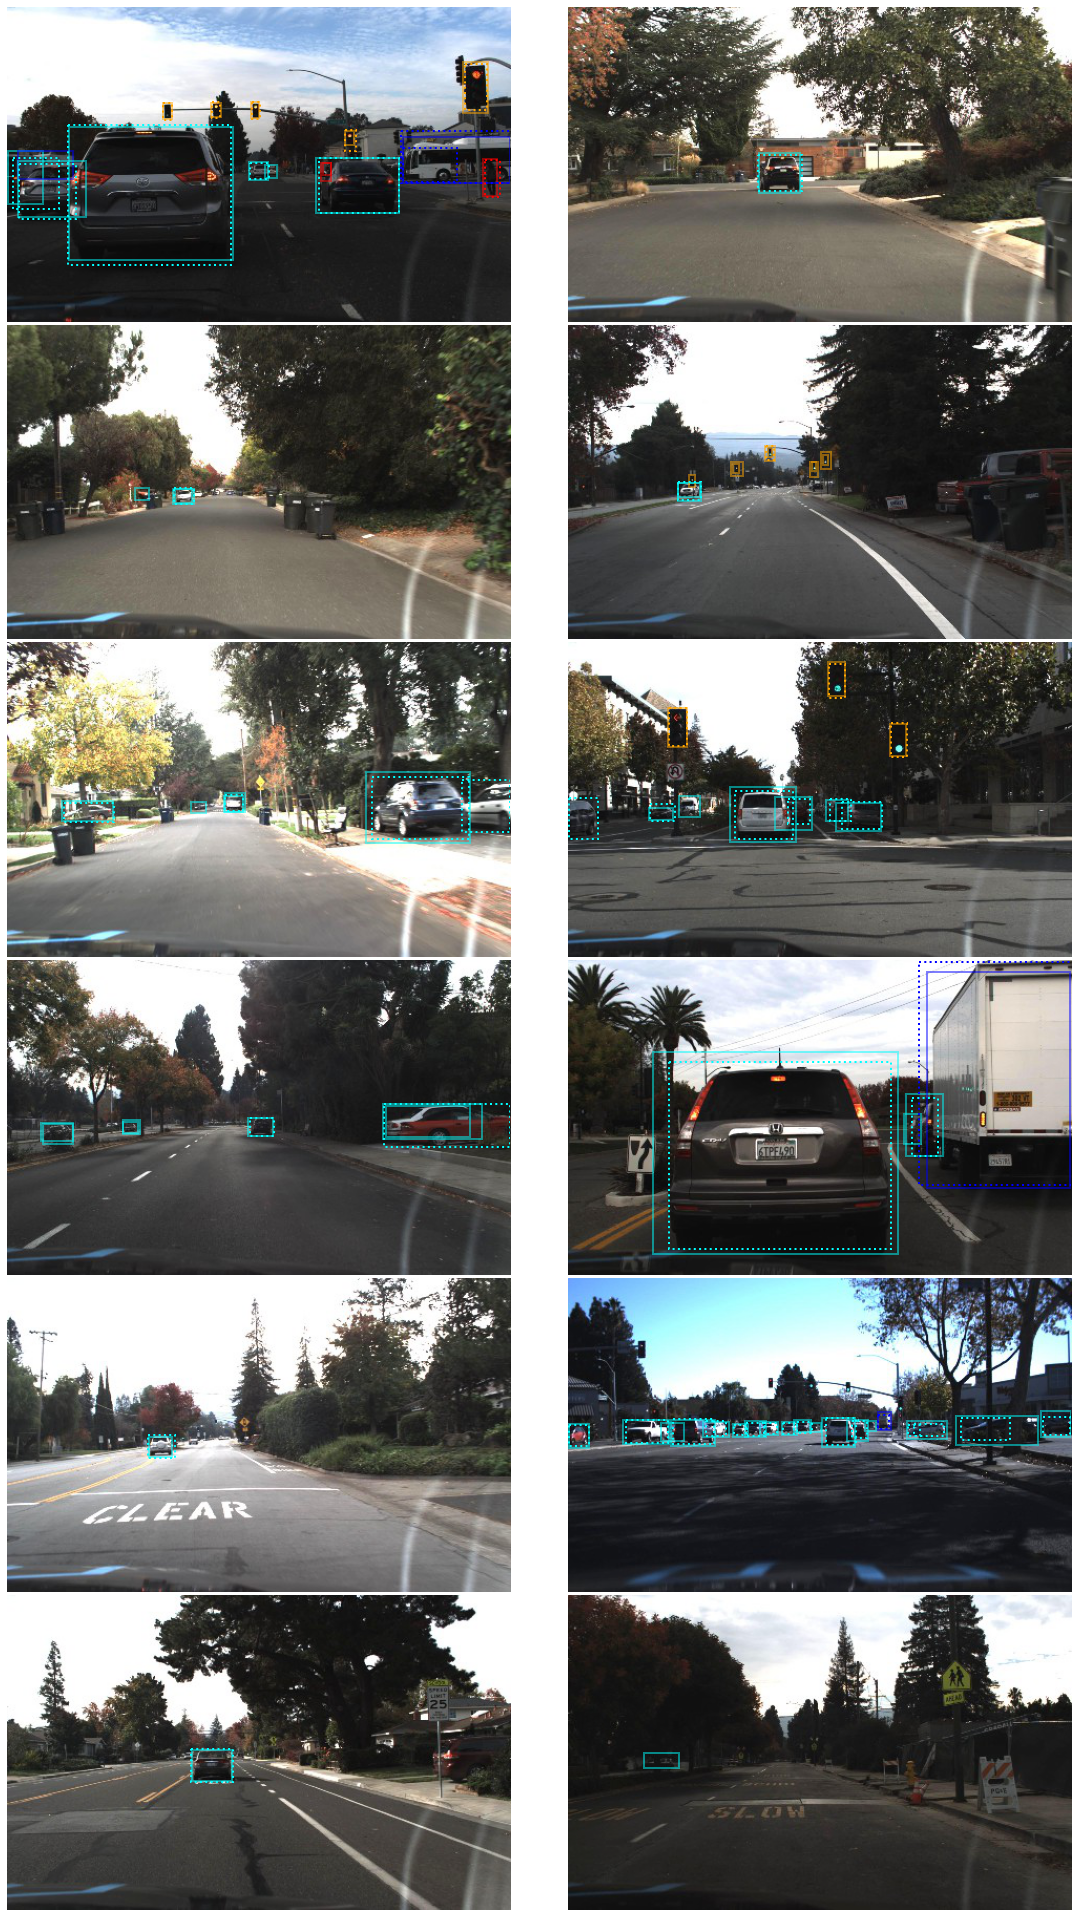

In [6]:
import matplotlib.pyplot as plt

model.eval()

fig, subs = plt.subplots(6, 2, figsize=(20, 35))
plt.subplots_adjust(wspace=0.01, hspace=0.01)

torch.manual_seed(42)

perm = torch.randperm(len(data_loaders['test'].dataset))
sel = perm[:subs.flatten().shape[0]]

for i, sub in zip(sel.squeeze(), subs.flatten()):
    
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_aspect('equal')
    
    image, labels = data_loaders['test'].dataset[i]

    predictions = model([image.cuda()])

    _ = data_loaders['test'].dataset.plot(i, predictions=predictions[0], ax=sub)